# Progetto IronITA
###### Progetto realizzato da Simona Sette (544298)

La task selezionata è stata IronITA (Irony Detection in Italian Tweets, http://www.di.unito.it/~tutreeb/ironita-evalita18/index.html), con specifico focus alla subtask A:
    
A) Rilevazione dell'ironia: la prima subtask consiste in un'attività di classificazione binaria in cui il sistema deve prevedere se un tweet è ironico o meno.

In [87]:
import pandas as pd
import numpy as np
import csv
import os.path
import sqlite3
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from collections import defaultdict
import math
from sklearn.preprocessing import MaxAbsScaler

Il notebook è organizzato in tre distinte parti.

Le tre parti sono eseguibili sia a cascata che singolarmente. 

La modalità di default è l'esecuzione a cascata, quindi nel caso si volesse eseguire la parte 3 singolarmente è necessario cambiare il tipo di cella ove indicato.

In [88]:
# Leggo il dataframe csv e creo i dataframe per il train e test a seconda del contenuto della feature set
df = pd.read_csv('data/Dataset/dataset_ironita_2018.csv', delimiter=",")  

df_train = df[df["set"] == "training"]

df_test = df[df["set"] == "test"]

## Baseline di classificazione binaria

In [89]:
# Calcolo delle occorrenze dei valori nella feature 'Irony'
occurrences = df_train['irony'].value_counts()
print(occurrences)

1    2023
0    1954
Name: irony, dtype: int64


Data la distribuzione equilibrata delle due classi nel dataset di addestramento e supponendo una strategia di classificazione casuale è possibile affermare che la baseline si attesta intorno al 50% di accuracy.

# Parte 1
1. Sviluppare un classificatore basato su SVM lineari che prende in input una rappresentazione del testo basata solo su informazioni linguistiche non lessicali estratte utilizzando il sistema Profiling-UD. Riportare i seguenti risultati:
- valutazione del sistema con un processo di 5-fold cross validation condotto sul training
set;
- valutazione del sistema sul test set ufficiale del task;
- elenco delle 15 feature più importanti per la classificazione.

## Lettura dei dataframe di Train e Test

In [3]:
df_train_features = pd.read_csv('data/profiling_output/profiling_training/6712.csv', delimiter="\t") 
df_test_features = pd.read_csv('data/profiling_output/profiling_test/6711.csv', delimiter="\t") 

In [4]:
# Stampiamo il numero di istanze e feature dei due set dati
print(df_train_features.shape)
print(df_test_features.shape)

(3977, 134)
(872, 131)


Possiamo constatare un numero di feature diseguali estratte dai due set di dati: l'approccio utilizzato è stato di compensazione, ovvero al test set sono state aggiunte le 3 feature mancanti riempite di zeri.

In [5]:
# Estrazione feature mancanti al test set
missing_features = list(set(df_train_features.columns) - set(df_test_features.columns))
print(missing_features)

['aux_form_dist_Ger', 'subordinate_dist_5', 'dep_dist_dislocated']


In [6]:
# Aggiunta a test set le feature mancanti riempite di zeri
for feature in missing_features:
    df_test_features[feature] = 0
    
# Controllo se le feature dei due set risultano ancora diseguali
missing_features = list(set(df_train_features.columns) - set(df_test_features.columns))
print(missing_features)

[]


In [7]:
df_train_features

,Filename,n_sentences,n_tokens,tokens_per_sent,char_per_tok,upos_dist_ADJ,upos_dist_ADP,upos_dist_ADV,upos_dist_AUX,upos_dist_CCONJ,...,principal_proposition_dist,subordinate_proposition_dist,subordinate_post,subordinate_pre,avg_subordinate_chain_len,subordinate_dist_1,subordinate_dist_2,subordinate_dist_3,subordinate_dist_4,subordinate_dist_5
0,training_set_txtfiles/521612052084051968.conllu,1,12,12.000000,6.400000,16.666667,8.333333,0.000000,0.000000,0.000000,...,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,training_set_txtfiles/531765030703104001.conllu,3,17,5.666667,7.000000,11.764706,5.882353,5.882353,5.882353,0.000000,...,66.666667,33.333333,100.0,0.0,1.0,100.0,0.0,0.0,0.0,0.0
2,training_set_txtfiles/135703391727923200.conllu,1,14,14.000000,5.846154,14.285714,14.285714,0.000000,0.000000,7.142857,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,training_set_txtfiles/511425860826828800.conllu,3,23,7.666667,4.476190,0.000000,13.043478,0.000000,4.347826,4.347826,...,50.000000,50.000000,100.0,0.0,1.0,100.0,0.0,0.0,0.0,0.0
4,training_set_txtfiles/149518352308633600.conllu,2,16,8.000000,6.066667,6.250000,12.500000,18.750000,6.250000,0.000000,...,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3972,training_set_txtfiles/578421137715163137.conllu,1,24,24.000000,4.750000,0.000000,12.500000,8.333333,4.166667,4.166667,...,0.000000,100.000000,0.0,100.0,1.0,100.0,0.0,0.0,0.0,0.0
3973,training_set_txtfiles/806465004325240832.conllu,1,8,8.000000,12.285714,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,100.000000,100.0,0.0,1.0,100.0,0.0,0.0,0.0,0.0
3974,training_set_txtfiles/512521225055510528.conllu,2,22,11.000000,5.476190,0.000000,9.090909,4.545455,0.000000,4.545455,...,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3975,training_set_txtfiles/193259823662497792.conllu,2,26,13.000000,4.869565,3.846154,19.230769,3.846154,3.846154,3.846154,...,33.333333,66.666667,100.0,0.0,1.0,100.0,0.0,0.0,0.0,0.0


## Aggiungiamo la label al dataframe delle feature estratte da profiling-UD

In [8]:
#TRAIN SET

#Creo la feature Irony nel train dataframe assegnandogli temporaneamente valori none
df_train_features = df_train_features.assign(irony=None)

# Costruisco un dizionario contente elementi aventi come chiave l'id numerico del tweet e come valore la classe irony
id_to_irony = {}
for index, row in df_train.iterrows():
    ID = int(row['twitter_id'])
    id_to_irony[ID] = row['irony']

# Assegnazione i valori di irony al dataframe contenete le feature 
for index, row in df_train_features.iterrows():
    # In ID pulisco il contenuto di Filename da qualsiasi cosa che non sia numerico
    ID = int(re.sub('[^0-9]', '', row['Filename']))
    # Se l'ID viene trovato nel dizionario creato prima assegno il valore di irony contenuto nel dizionario all'istanza corrente del dataframe delle feature
    if ID in id_to_irony:
        df_train_features.at[index, 'irony'] = id_to_irony[ID]

In [9]:
#TEST SET

# Creo la feature Irony nel train dataframe assegnandogli temporaneamente valori none
df_test_features = df_test_features.assign(irony=None)

# Costruisco un dizionario contente elementi aventi come chiave l'id numerico del tweet e come valore la classe irony
id_to_irony = {}
for index, row in df_test.iterrows():
    ID = int(row['twitter_id'])
    id_to_irony[ID] = row['irony']

# Assegnazione i valori di irony al dataframe contenete le feature 
for index, row in df_test_features.iterrows():
    # In ID pulisco il contenuto di Filename da qualsiasi cosa che non sia numerico
    ID = int(re.sub('[^0-9]', '', row['Filename']))
    # Se l'ID viene trovato nel dizionario creato prima assegno il valore di irony contenuto nel dizionario all'istanza corrente del dataframe delle feature
    if ID in id_to_irony:
        df_test_features.at[index, 'irony'] = id_to_irony[ID]


In [10]:
# Rimuovo la colonna Filename in quanto non utile alla classificazione
df_test_features = df_test_features.drop(columns=["Filename"])
df_train_features = df_train_features.drop(columns=["Filename"])

In [11]:
df_train_features

,n_sentences,n_tokens,tokens_per_sent,char_per_tok,upos_dist_ADJ,upos_dist_ADP,upos_dist_ADV,upos_dist_AUX,upos_dist_CCONJ,upos_dist_DET,...,subordinate_proposition_dist,subordinate_post,subordinate_pre,avg_subordinate_chain_len,subordinate_dist_1,subordinate_dist_2,subordinate_dist_3,subordinate_dist_4,subordinate_dist_5,irony
0,1,12,12.000000,6.400000,16.666667,8.333333,0.000000,0.000000,0.000000,8.333333,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,3,17,5.666667,7.000000,11.764706,5.882353,5.882353,5.882353,0.000000,5.882353,...,33.333333,100.0,0.0,1.0,100.0,0.0,0.0,0.0,0.0,0
2,1,14,14.000000,5.846154,14.285714,14.285714,0.000000,0.000000,7.142857,14.285714,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,23,7.666667,4.476190,0.000000,13.043478,0.000000,4.347826,4.347826,13.043478,...,50.000000,100.0,0.0,1.0,100.0,0.0,0.0,0.0,0.0,1
4,2,16,8.000000,6.066667,6.250000,12.500000,18.750000,6.250000,0.000000,12.500000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3972,1,24,24.000000,4.750000,0.000000,12.500000,8.333333,4.166667,4.166667,12.500000,...,100.000000,0.0,100.0,1.0,100.0,0.0,0.0,0.0,0.0,1
3973,1,8,8.000000,12.285714,0.000000,0.000000,0.000000,0.000000,0.000000,12.500000,...,100.000000,100.0,0.0,1.0,100.0,0.0,0.0,0.0,0.0,1
3974,2,22,11.000000,5.476190,0.000000,9.090909,4.545455,0.000000,4.545455,18.181818,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3975,2,26,13.000000,4.869565,3.846154,19.230769,3.846154,3.846154,3.846154,15.384615,...,66.666667,100.0,0.0,1.0,100.0,0.0,0.0,0.0,0.0,1


Le tre feature aggiunte al test set vengono appese a fine dataframe e noi serve che siano allineate con il train set per definire la feature importance in modo corretto. 
Li riallineiamo definendo come ordine corretto quello del train set.

In [12]:
# Definisco l'ordine delle colonne come quello del set di train
column_order = df_train_features.columns

# Allineo le colonne del dataset di test in base all'ordine definito sopra
df_test_features = df_test_features.reindex(columns=column_order)

# Controllo di verifica corretto reindexing
nomi_colonne1 = list(df_train_features.columns)
nomi_colonne2 = list(df_test_features.columns)

# Itera sui nomi delle colonne delle due liste contemporaneamente per confrontare le stringhe
if all(nome1 == nome2 for nome1, nome2 in zip(nomi_colonne1, nomi_colonne2)):
    print("Le feature sono in ordine corretto.")
else:
    print("Le feature sono in ordine non corretto.")

Le feature sono in ordine corretto.


## Inizio preparazione alla classificazione

In [13]:
# Definisco dataframe di train e test sia per le feature che per la classe
X_train = df_train_features.drop("irony", axis=1)
X_test = df_test_features.drop("irony", axis=1)
y_train = df_train_features['irony'].astype(int)
y_test = df_test_features['irony'].astype(int)

In [14]:
# Definisco come scaler il MinMax, effettuo il fit_trasform sul train e la trasform sul test 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Creazione dei 5 fold su cui verrà eseguita la classificazione:

In [15]:
# Salvo in feature_names i nomi delle feature (valgono sia per train che per test in quanto allineati)
features_names= nomi_colonne1
# Salvo in un numpy array le classi del train set
y_train = np.asarray(y_train)

In [16]:
# Definisco lo splitter con 5 split, una mescolanza dei dati pre split e con seed 42
splitter = KFold(n_splits=5, random_state=42, shuffle=True)
# Effettuo lo split e salvo gli split in folds
folds = list(splitter.split(X_train))

# Visualizzo tramite ciclo il numero di istanze di train e validation per ogni fold
for i in range(len(folds)):
    print(len(folds[i][0]), len(folds[i][1]))

3181 796
3181 796
3182 795
3182 795
3182 795


In [17]:
# Lista per memorizzare le predizioni e le classi reali su tutti i fold
all_y_true = []
all_y_pred = []
# Lista per memorizzare i coefficienti (classe positiva) dei modelli
FI_coefficienti_kfold = []
# Lista per memorizzare i coefficienti (classe negativa) dei modelli
FI_coefficienti_kfold_0 = []

# Per ciascun fold
for i in range(len(folds)):
    
    # Estraggo gli indici di train e validation (qui e di seguito definito test) per il fold corrente
    train_ids = folds[i][0]
    test_ids = folds[i][1]
    
     # Suddivido i dati in train e validation per il fold corrente tramite la localizzazione degli ID estratti in folds
    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]

    fold_X_test = X_train[test_ids]
    fold_y_test = y_train[test_ids]
    
    # Creo un classificatore LinearSVC
    kfold_svc = LinearSVC()
    
    # Addestro il classificatore sul set di train del fold corrente
    kfold_svc.fit(fold_X_train, fold_y_train)
    
    # Eseguo le previsioni sul set di validation del fold corrente
    fold_y_pred = kfold_svc.predict(fold_X_test)
    
    # Calcolo l'accuratezza del modello sul fold corrente
    fold_accuracy = accuracy_score(fold_y_test, fold_y_pred)
    # Stampo l'accuratezza del fold corrente
    print(f"Accuracy fold {i+1}: {fold_accuracy}")

    # Aggiungo le previsioni e i valori reali delle classi del fold corrente alle liste complessive
    all_y_true += fold_y_test.tolist()
    all_y_pred += fold_y_pred.tolist()
    
    # Estrae i coefficienti del modello per ciascuna variabile (classe positiva)
    coefs = kfold_svc.coef_
    
    # Indici per accedere ai coefficienti delle classi positive e negative
    idx = 0
   
    # Coefficienti per la classe positiva e negativa
    class_coefs = coefs[idx]
 
    # Creo un dizionario dei coefficienti delle variabili per la classe positiva e negativa
    feature_importances = {feature_name: coef for feature_name, coef in zip(features_names, class_coefs)}
    
    # Memorizzo dei coefficienti del modello k-fold
    FI_coefficienti_kfold.append(feature_importances)
 

Accuracy fold 1: 0.6809045226130653
Accuracy fold 2: 0.6268844221105527
Accuracy fold 3: 0.6440251572327044
Accuracy fold 4: 0.6767295597484276
Accuracy fold 5: 0.6515723270440251


In [18]:
# Stampo il report di classificazione generale per tutti i fold
print(classification_report(all_y_true, all_y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.66      0.61      0.64      1954
           1       0.65      0.70      0.67      2023

    accuracy                           0.66      3977
   macro avg       0.66      0.66      0.65      3977
weighted avg       0.66      0.66      0.66      3977



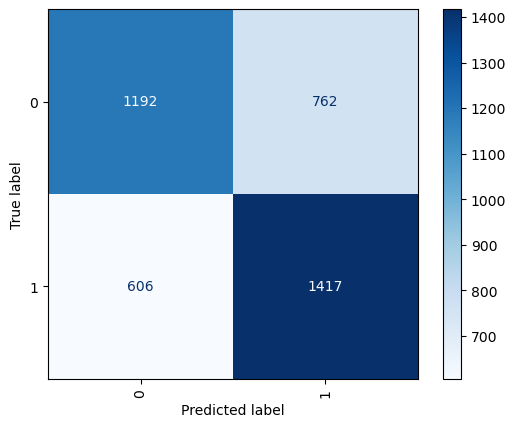

In [19]:
# Mostro matrice di confusione per tutti i fold
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, xticks_rotation='vertical', cmap='Blues');

In [20]:
# Effettuo previsione sul test set e mostro classification report sul test set
test_predictions = kfold_svc.predict(X_test)
print(classification_report(y_test, test_predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.69      0.60      0.64       437
           1       0.65      0.73      0.69       435

    accuracy                           0.67       872
   macro avg       0.67      0.67      0.67       872
weighted avg       0.67      0.67      0.67       872



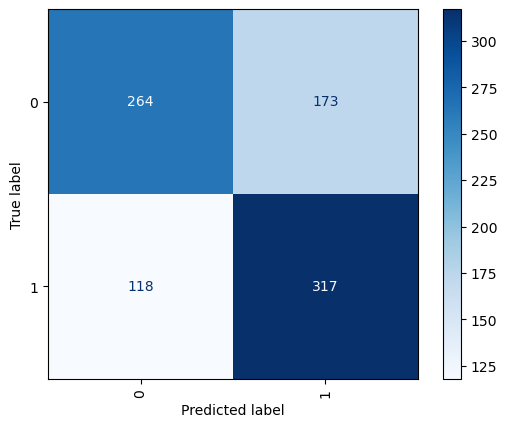

In [21]:
# Mostro matrice di confusione per il test set
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions, xticks_rotation='vertical', cmap='Blues');

## Feature Importance

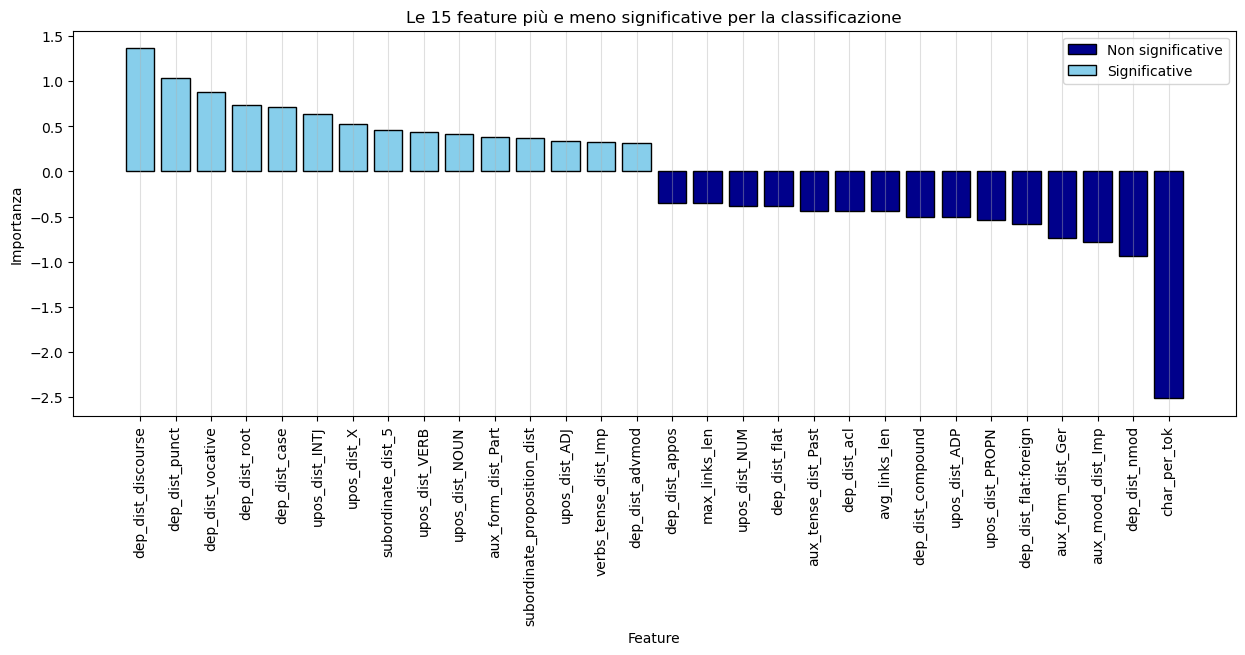

In [61]:
# Assegno a queste liste i dizionari contenenti i valori dei coefficienti per i 5 fold (sia classe positiva che negativa)
list_of_dicts = FI_coefficienti_kfold

# Conterrà liste di valori suddivisi per chiave, viene riempita dopo il ciclo che segue
result_dict = defaultdict(list)

# Per ogni dizionario nella lista
for d in list_of_dicts:
    # Per ogni chiave nel dizionario
    for key, value in d.items():
        # Aggiungo il valore alla lista corrispondente alla chiave
        result_dict[key].append(value)

        
# Per ogni chiave nel dizionario risultante
for key, value in result_dict.items():
    # Calcola la media dei valori
    avg_value = sum(value) / len(value)
    # Aggiungo la media come valore della chiave
    result_dict[key] = avg_value
    
# Converto result_dict in un dizionario standard (non più defaultdict)
result_dict = dict(result_dict)
# Effettuo un ordinamento decrescente dei coefficienti con annesse feature
sorted_feature_importances = dict(sorted(result_dict.items(), key=lambda item: item[1], reverse=True))

# Salvo nelle variabili i nomi e i valori delle prime e ultime 15 feature discriminanti per la classificazione
top_features = list(sorted_feature_importances.keys())[:15] + list(sorted_feature_importances.keys())[-15:]
top_coef_values = list(sorted_feature_importances.values())[:15] + list(sorted_feature_importances.values())[-15:]

# Colori delle barre
colors = ['darkblue' if val < 0 else 'skyblue' for val in top_coef_values]

# Plot delle coppie chiave-valore in ordine decrescente
plt.figure(figsize=(15, 5))
plt.bar(top_features, top_coef_values, color=colors, edgecolor='black')
plt.xlabel('Feature')
plt.ylabel('Importanza')
plt.xticks(rotation=90, fontsize=10)
plt.title('Le 15 feature più e meno significative per la classificazione')
plt.grid(axis='x', alpha=0.4)
# Crea una lista di oggetti Patch per la legenda
legend_patches = [Patch(facecolor='darkblue', edgecolor='black', label='Non significative'), Patch(facecolor='skyblue', edgecolor='black', label='Significative')]
# Crea la legenda personalizzata
plt.legend(handles=legend_patches)
plt.show()

# Parte 2
Sviluppare un classificatore basato su SVM lineari che prende in input una rappresentazione del testo basata su n-grammi di caratteri, parole e part-of-speech. Riportare i seguenti risultati:
- testare diverse rappresentazioni del testo che variano rispetto alla lunghezza degli ngrammi utilizzati e/o rispetto al tipo di informazione utilizzata all’interno degli ngrammi (forme, lemmi, caratteri, part-of-speech) e valutare i diversi sistemi con un
processo di 5-fold cross validation condotto sul training set.
- valutazione sul test set ufficiale del miglior sistema rispetto ai risultati ottenuti con il
processo di 5-fold cross validation del punto sopra .

In [62]:
# Salvo i path per i dati di train e test
conllu_dir = 'data/profiling_output'
train_dir = os.path.join(conllu_dir, 'profiling_training/train')
test_dir = os.path.join(conllu_dir, 'profiling_test/test')

In [63]:
# Salvo in una lista i nomi dei file di train e test
train_files = []
test_files = []

# Itero su tutti i file presenti nella directory di train
for file_name in os.listdir(train_dir):
    # Creo il percorso completo del file
    file_path = os.path.join(train_dir, file_name)
    # Se il nome del file termina con '.conllu'
    if file_name.endswith('.conllu'):
        # Aggiungo il percorso del file alla lista dei file di train
        train_files.append(file_path)

        
# Itero su tutti i file presenti nella directory di test
for file_name in os.listdir(test_dir):
    # Creo il percorso completo del file
    file_path = os.path.join(test_dir, file_name)
    # Se il nome del file termina con '.conllu'
    if file_name.endswith('.conllu'):
        # Aggiungo il percorso del file alla lista dei file di train
        test_files.append(file_path)

# Controllo se il numero di file corrispondono all'effettiva dimensione dei set
print('Documenti training set:', len(train_files))
print('Documenti test set:', len(test_files))

Documenti training set: 3977
Documenti test set: 872


## Recupero labels coerenti con l'ordine dei file in train e test files

In [64]:
# TRAIN SET: Mapping ed estrazione label 

# Creo un dizionario vuoto per associare ogni twitter_id al proprio valore di irony
train_dict = {}

# Itero sul dataframe df_train
for index, row in df_train.iterrows():
    # Salvo la label irony nel dizionario usando il twitter_id come chiave
    train_dict[str(row['twitter_id'])] = row['irony']
    
# Creo una lista vuota per salvare le label di output del training set
y_train = []

# Per ogni nome di file di train 
for i in train_files:
    # Estraggo dell'ID numerico dal nome del file
    ID = re.sub('[^0-9]', '', i)
     # Aggiungo il valore di irony alla lista di output quando trovo una corrispondenza nel dizionario (if cerca tramite chiavi di train_dict)
    if ID in train_dict:
        y_train.append(train_dict[ID])
    else:
        print(f"Errore: ID {ID} non trovato nel DataFrame df_train")

In [65]:
# TEST SET: Mapping ed estrazione label 
        
# Creo un dizionario vuoto per associare ogni twitter_id al proprio valore di irony
test_dict = {}

# Itero sul dataframe df_test
for index, row in df_test.iterrows():
    # Salvo la label irony nel dizionario usando il twitter_id come chiave
    test_dict[str(row['twitter_id'])] = row['irony']
    
# Creo una lista vuota per salvare le label di output del test_set
y_test = []

# Per ogni nome di file di test 
for i in test_files:
   # Estraggo dell'ID numerico dal nome del file
    ID = re.sub('[^0-9]', '', i)
    # Aggiungo il valore di irony alla lista di output quando trovo una corrispondenza nel dizionario (if cerca tramite chiavi di test_dict)
    if ID in test_dict:
        y_test.append(test_dict[ID])
    else:
        print(f"Errore: ID {ID} non trovato nel DataFrame df_test")

## Estraggo l'annotazione linguistica usando i path dei file e li salvo in una lista ad hoc per il train e test

In [66]:
# Per ogni file conllu nelle cartelle del src_path estrae l'annotazione delle frasi:
# Ogni frase si trova in una lista e le annotazioni dei singoli token sono contenuti in una struttura dati dizionario

def get_sentences_from_file(src_path):

    # Lista che conterrà tutte le frasi in un file
    sentences_infile = []               
    # Lista usata per costruire una frase alla volta
    sentence = []                      
    
    # Per ogni riga in percorso nella lista dei percorsi dei file 
    for line in open(src_path, 'r', encoding='utf-8'):
        
        # Controlla se il primo carattere della riga è un numero, se lo è:
        if line[0].isdigit():          
            # Separa la riga utilizzando il tabulatore come separatore e rimuove gli spazi iniziali e finali
            splitted_line = line.strip().split('\t')
            # Se l'ID della parola non contiene un trattino nel primo elemento di splitted line (dove si trovano i numeri, serve per escludere le righe che hanno 2 numeri separati da trattino)
            if '-' not in splitted_line[0]: 
                # Costruisco un dizionario (per ogni token)
                token = {
                    # Assegna il secondo elemento della splitted_line alla chiave 'word'
                    'word': splitted_line[1],
                    # Assegna il terzo elemento della splitted_line alla chiave 'lemma'
                    'lemma': splitted_line[2],
                    # Assegna il quarto elemento della splitted_line alla chiave 'pos'
                    'pos': splitted_line[3]
                }
                # Appendo il token alla lista delle frasi 
                sentence.append(token)
                
        # Se la riga è vuota significa che la frase è finita
        if line == '\n':  
            # Appendo la lista contenente i dizionari alla lista delle frasi nel file
            sentences_infile.append(sentence)
            # Ripulisco il contenuto di sentence
            sentence = []
    # Restituisco la lista contenente la lista di frasi in un file
    return sentences_infile


In [67]:
# Per ogni file nelle cartelle dei dataset invoca la funzione get_sentences_from_file e appende la lista restituita alla variabile dataset, restituendolo.
def get_dataset_from_files(file_paths):
    
    # Lista che conterrà la lista delle frasi in un file per ogni file del dataset
    dataset = []
    # Per ogni file path nella lista dei file_paths 
    for file_path in file_paths:
        # Invoca la funzione definita in precedenza
        sentences_infile = get_sentences_from_file(file_path)
        # Appende sentences_infile restituito (quindi la lista delle frasi contenute in un singolo file)
        dataset.append(sentences_infile)
        
    # Restituisce una lista che contiene la lista delle frasi contenute nei file di un dataset
    return dataset

In [68]:
#Invoco la funzione definita precedentemente sulle liste contenenti i percorsi dei file di train e test
train_dataset = get_dataset_from_files(train_files)
test_dataset = get_dataset_from_files(test_files)

# Controllo se il numero di file corrispondono all'effettiva dimensione dei set
print('Documenti training set:', len(train_dataset))
print('Documenti test set:', len(test_dataset))

Documenti training set: 3977
Documenti test set: 872


In [69]:
#TESTING 
for i in range(2):
    print("File in train -->",train_dataset[i] ,"\n Label del file -->", y_train[i], "\n")

File in train --> [[{'word': 'Le', 'lemma': 'il', 'pos': 'DET'}, {'word': '5', 'lemma': '5', 'pos': 'NUM'}, {'word': 'sgradevoli', 'lemma': 'sgradevole', 'pos': 'ADJ'}, {'word': 'realtà', 'lemma': 'realtà', 'pos': 'NOUN'}, {'word': 'di', 'lemma': 'di', 'pos': 'ADP'}, {'word': 'cui', 'lemma': 'cui', 'pos': 'PRON'}, {'word': 'Berlusconi', 'lemma': 'Berlusconi', 'pos': 'PROPN'}, {'word': 'dovrebbe', 'lemma': 'dovere', 'pos': 'AUX'}, {'word': 'render', 'lemma': 'rendere', 'pos': 'VERB'}, {'word': 'si', 'lemma': 'si', 'pos': 'PRON'}, {'word': 'personalmente', 'lemma': 'personalmente', 'pos': 'ADV'}, {'word': 'conto', 'lemma': 'conto', 'pos': 'NOUN'}, {'word': 'http://t.co/G3u1iF9n', 'lemma': 'http://t.co/G3u1iF9n', 'pos': 'PROPN'}, {'word': 'Mario', 'lemma': 'Mario', 'pos': 'PROPN'}, {'word': 'Monti', 'lemma': 'Monti', 'pos': 'PROPN'}, {'word': 'non', 'lemma': 'non', 'pos': 'ADV'}, {'word': 'usa', 'lemma': 'usare', 'pos': 'VERB'}, {'word': 'mezzi', 'lemma': 'mezzo', 'pos': 'ADJ'}, {'word': 

##  Fase di generazione features dati Word, Lemma e Part of Speech 

Funzioni per estrazioni ngrammi di caratteri e parole:

In [70]:
# Estrae gli n-grammi di parole da una frase e li aggiunge a un dizionario word_ngrams.
# Argomenti: il dizionario che restituirà in output (conterrà gli n-grammi di parole), la lista di token contenuti in una frase, da quale chiave estrarre l'n-gram (es. 'word', 'lemma', 'pos'), la lunghezza degli n-grams da estrarre
       
def extract_word_ngrams(word_ngrams, sentence, el, n):
    
    # Creiamo una lista con i valori corrispondenti alla chiave el della frase
    all_words = []
    # Per i token in una frase
    for token in sentence:
        # Appendi alla lista all_words il valore corrispondente alla chiave el
        all_words.append(token[el])
    
    # Scorriamo la lista dei valori corrispondenti alla chiave el ed estraiamo gli n-grammi
    for i in range(0, len(all_words) - n + 1):
        
        # Estraiamo l'n-gramma (n in input) dell'elemento corrente
        ngram_words = all_words[i: i + n]
        # Creiamo una stringa che rappresenta l'n-gramma: la chiave in maiuscolo, "_", l'ordine del valore nella frase,"_" e il valore ngram_words
        ngram = f'{el.upper()}_{n}_' + '_'.join(ngram_words)
        
        #print(f'{i}: {ngram_words} -> {ngram}')
        # Es: per n=1--> 0: ['Le'] -> WORD_1_Le; per n=2--> 1: ['5', 'sgradevoli'] -> WORD_2_5_sgradevoli
        
        # Se l'ngram non è già presente tra gli ngrammi di elementi, lo aggiungiamo ad esso (nuova key) e inseriamo frequenza 1 (value)
        if ngram not in word_ngrams:
            word_ngrams[ngram] = 1
        # Altrimenti in corrispondenza dell'ngram (key) aumentiamo la frequenza (valore) di 1
        else:
            word_ngrams[ngram] += 1
            
    # Restituisco dizionario word_ngrams dove la chiave è l'n-gram e il valore e la frequenza
    return word_ngrams

In [71]:
# Estrae gli n-grammi di caratteri (case sensitive) da una frase e li aggiunge a un dizionario word_ngrams.

def extract_char_ngrams(char_ngrams, sentence, n):
    
    # Creiamo una lista con i valori corrispondenti alla word della frase
    all_words = []
    # Per i token in una frase
    for token in sentence:
        # Appendi alla lista all_words i valori corrispondenti alla word 
        all_words.append(token['word'])

    # Creiamo una stringa che contenga tutte le parole separate tra spazi perchè vogliamo scorrere i caratteri
    all_words = ' '.join(all_words)
    
    # Scorriamo la stringa delle parole
    for i in range(0, len(all_words) - n + 1):
        # Estraiamo l'n-gramma (n in input) dell'elemento corrente
        ngram_chars = all_words[i:i + n]
        # Creiamo una stringa che rappresenta l'n-gramma di caratteri:  "CHAR_", il numero n dell'ngram passato in input, "_" e il valore ngram_chars
        ngram = f'CHAR_{n}_' + ngram_chars
        
        #print(f'{i}: {ngram_chars} -> {ngram}')
        #se n=2-->0: Le -> CHAR_2_Le; se n=1--> 0: L -> CHAR_1_L

        # Se l'ngram non è già presente tra gli ngrammi di elementi, lo aggiungiamo ad esso (nuova key) e inseriamo frequenza 1 (value)
        if ngram not in char_ngrams:
            char_ngrams[ngram] = 1
        # Altrimenti in corrispondenza dell'ngram (key) aumentiamo la frequenza (valore) di 1
        else:
            char_ngrams[ngram] += 1
    
    # Restituisco dizionario word_ngrams dove la chiave è l'n-gram e il valore e la frequenza
    return char_ngrams

Si è deciso di implementare la normalizzazione degli n-grammi in quanto prima dell'anno 2017 il limite di dimensione dei tweet in termini di caratteri era impostato a 140, ma nel corso dello stesso anno il numero di caratteri consentiti è stato raddoppiato. 

Per via della dimensione già di per sè ridotta, una duplicazione di caratteri consentiti potrebbe riflettersi in un notevole impatto sulla distribuzione e sulla frequenza degli n-grammi estratti dai tweet a seconda del periodo di scraping di questi. 

Si è considerato il fatto che questo task risale al 2018 e lo scaping dei tweet può essere avvenuto in un periodo sia precedente che successivo al suddetto anno.

Per questo motivo si è ritenuto ragionevole effettuare la normalizzazione degli n-grammi per garantire un confronto equo e accurato delle frequenze tra tweet raccolti in periodi diversi, prima e dopo il cambiamento del limite di caratteri.

In [72]:
# Conta il numero totale di parole in un tweet (insieme di frasi).
def count_document_words(document):
    num_words = 0
    # Per ogni frase in un documento
    for sentence in document:
        # Assegno a num_words il suo stesso valore sommato al numero di parole nella frase corrente
        num_words = num_words + len(sentence)
    return num_words

# Conta il numero totale di caratteri in un tweet (insieme di frasi).
def count_document_chars(document):
    num_chars = 0
    # Per ogni frase in un documento
    for sentence in document:

        # Per ogni token in una frase
        for token in sentence:
            
            # Assegno a num_chars il suo stesso valore sommato al numero di caratteri nella parola corrente 
            num_chars = num_chars + len(token['word'])

        # Assegno a num_chars il suo stesso valore sommato al numero di parole nella frase corrente - 1
        # Contiamo anche gli spazi che separano le parole (1 per parola esclusa la parola a fine frase, per cui len(sentence)-1 permette di rappresentare spazi tra tutte le parole tranne l'ultima)
        num_chars = num_chars + len(sentence) - 1  
    return num_chars

# Normalizza la frequenza degli n-grammi di un dizionario (di ngrammi di parole o caratteri) in base al numero di caratteri o parole.
def normalize_ngrams(ngrams_dict, doc_len):
    # Per ogni ngram nel dizionario
    for ngram in ngrams_dict:
        # Riassegno come valore il suo precedente diviso il numero di caratteri o parole
        ngrams_dict[ngram] = ngrams_dict[ngram]/float(doc_len)

### 1) Logica per l'estrazione delle feature: le feature consistono in bigrammi e unigrammi di caratteri e parole 

In [73]:
#Estrae le features degli n-grammi di parole e caratteri da un dataset di documenti.

def extract_features_1(dataset):
    
    dataset_features = []
    # Per ogni tweet del dataset creo 4 nuovi dizionari
    for document in dataset:
        word_unigrams = dict()
        word_bigrams = dict()
        char_unigrams = dict()
        char_bigrams = dict()
        
        # Per ogni frase in un tweet vengono popolati i dizionari 
        for sentence in document:
            
            # Estraiamo i bigrammi e unigrammi di caratteri e parole 
            extract_word_ngrams(word_unigrams, sentence, 'word', 1)
            extract_word_ngrams(word_bigrams, sentence, 'word', 2)
            extract_char_ngrams(char_unigrams, sentence, 1)
            extract_char_ngrams(char_bigrams, sentence, 2)
            
            # Contiamo il numero di caratteri e parole per ogni tweet
            num_words = count_document_words(document)
            num_chars = count_document_chars(document)
            
            # Normalizziamo gli ngrammi estratti in precedenza con il numero totale di caratteri e parole a seconda del caso
            normalize_ngrams(word_unigrams, num_words)
            normalize_ngrams(word_bigrams, num_words)
            normalize_ngrams(char_unigrams, num_chars)
            normalize_ngrams(char_bigrams, num_chars)
        
        # Creiamo un dizionario di features per il tweet corrente, unendo tutti gli n-grammi
        tweet_features = dict()
        for ngrams_dict in [word_unigrams, word_bigrams, char_unigrams, char_bigrams]:
            for ngram in ngrams_dict:
                tweet_features[ngram] = ngrams_dict[ngram]

        dataset_features.append(tweet_features)
    return dataset_features

### 2) Logica per l'estrazione delle feature: le feature consistono in bigrammi e trigrammi di caratteri e parole 

In [74]:
#Estrae le features degli n-grammi di parole e caratteri da un dataset di documenti.

def extract_features_2(dataset):
    
    dataset_features = []
    # Per ogni tweet del dataset creo 4 nuovi dizionari
    for document in dataset:
        word_trigrams = dict()
        word_bigrams = dict()
        char_trigrams = dict()
        char_bigrams = dict()
        
        # Per ogni frase in un tweet vengono popolati i dizionari 
        for sentence in document:
            
            # Estraiamo i bigrammi e unigrammi di caratteri e parole 
            extract_word_ngrams(word_bigrams, sentence, 'word', 2)
            extract_word_ngrams(word_trigrams, sentence, 'word', 3)
            extract_char_ngrams(char_bigrams, sentence, 2)
            extract_char_ngrams(char_trigrams, sentence, 3)
            
            # Contiamo il numero di caratteri e parole per ogni tweet
            num_words = count_document_words(document)
            num_chars = count_document_chars(document)
            
            # Normalizziamo gli ngrammi estratti in precedenza con il numero totale di caratteri e parole a seconda del caso
            normalize_ngrams(word_trigrams, num_words)
            normalize_ngrams(word_bigrams, num_words)
            normalize_ngrams(char_trigrams, num_chars)
            normalize_ngrams(char_bigrams, num_chars)
        
        # Creiamo un dizionario di features per il tweet corrente, unendo tutti gli n-grammi
        tweet_features = dict()
        for ngrams_dict in [word_trigrams, word_bigrams, char_trigrams, char_bigrams]:
            for ngram in ngrams_dict:
                tweet_features[ngram] = ngrams_dict[ngram]

        dataset_features.append(tweet_features)
    return dataset_features

### 3) Logica per l'estrazione delle feature: le feature consistono in unigrammi e bigrammi di pos e parole

In [75]:
#Estrae le features degli n-grammi di parole e caratteri da un dataset di documenti.

def extract_features_3(dataset):
    
    dataset_features = []
    # Per ogni tweet del dataset creo 4 nuovi dizionari
    for document in dataset:
        word_unigrams = dict()
        word_bigrams = dict()
        pos_bigrams = dict()
        pos_unigrams = dict()
        
        # Per ogni frase in un tweet vengono popolati i dizionari 
        for sentence in document:
            
            # Estraiamo i bigrammi e unigrammi di caratteri e parole 
            extract_word_ngrams(word_bigrams, sentence, 'word', 2)
            extract_word_ngrams(word_unigrams, sentence, 'word', 1)
            extract_word_ngrams(pos_bigrams, sentence, 'pos', 2)
            extract_word_ngrams(pos_unigrams, sentence, 'pos', 1)
      
            # Contiamo il numero di parole per ogni tweet (sarà usato anche nel caso di pos in quanto ad ogni parola corrisponde un POS)
            num_words = count_document_words(document)
            
            # Normalizziamo gli ngrammi estratti in precedenza con il numero totale di caratteri e parole a seconda del caso
            normalize_ngrams(word_bigrams, num_words)
            normalize_ngrams(word_unigrams, num_words)
            normalize_ngrams(pos_bigrams, num_words)
            normalize_ngrams(pos_unigrams, num_words)
        
        # Creiamo un dizionario di features per il tweet corrente, unendo tutti gli n-grammi
        tweet_features = dict()
        for ngrams_dict in [word_bigrams, word_unigrams, pos_bigrams, pos_unigrams]:
            for ngram in ngrams_dict:
                tweet_features[ngram] = ngrams_dict[ngram]

        dataset_features.append(tweet_features)
    return dataset_features

In [76]:
# Invoco extract_features su train_dataset e test_dataset 
train_features_1 = extract_features_1(train_dataset)
test_features_1= extract_features_1(test_dataset)

# Invoco extract_features su train_dataset e test_dataset 
train_features_2 = extract_features_2(train_dataset)
test_features_2= extract_features_2(test_dataset)

# Invoco extract_features su train_dataset e test_dataset 
train_features_3 = extract_features_3(train_dataset)
test_features_3= extract_features_3(test_dataset)

In [77]:
# Controllo se il numero di file corrispondono all'effettiva dimensione dei set
print('Documenti training set:', len(train_features_1),",", len(train_features_2),",", len(train_features_3))
print('Documenti test set:', len(test_features_1),",", len(test_features_2),",", len(test_features_3))

Documenti training set: 3977 , 3977 , 3977
Documenti test set: 872 , 872 , 872


In [78]:
# Funzione per estrarre il numero di features dei dataset
def get_num_features(dataset):
    # Crea un insieme vuoto per contenere tutte le features uniche
    all_features = set()
    # Itera su ogni dizionario di features nel dataset
    for tweet_dict in dataset:
         # Aggiunge le chiavi (features) del dizionario all'insieme
        all_features.update(list(tweet_dict.keys()))
    # Restituisce il numero totale di features uniche
    return len(all_features)

print(f'Numero features caso 1: {get_num_features(train_features_1)}')
print(f'Numero features caso 1: {get_num_features(test_features_1)}')

print(f'Numero features caso 2: {get_num_features(train_features_2)}')
print(f'Numero features caso 2: {get_num_features(test_features_2)}')

print(f'Numero features caso 3: {get_num_features(train_features_3)}')
print(f'Numero features caso 3: {get_num_features(test_features_3)}')

Numero features caso 1: 69601
Numero features caso 1: 21428
Numero features caso 2: 137609
Numero features caso 2: 40153
Numero features caso 3: 64656
Numero features caso 3: 18117


## Applichiamo un filtro alle feature estratte al fine di conservare unicamente le più significative.

In [79]:
# Filtriamo le features in base alla loro frequenza nei tweet
def filter_features(train_features, min_occurrences):

    # Crea un dizionario vuoto per contare ogni feature in quanti tweet diversi compare
    features_counter = dict()
    
    # Itera su ogni dizionario di features in train_features
    for tweet_dict in train_features:
        # Itera su ogni feature nel dizionario
        for feature in tweet_dict:
            # Se la feature è già presente nel dizionario features_counter
            if feature in features_counter:
                # Incrementa il conteggio delle occorrenze di quella feature di 1
                features_counter[feature] += 1
            else:
                # Altimenti aggiunge la feature al dizionario e assegna il valore 1 al conteggio iniziale della frequenza
                features_counter[feature] = 1
                
    # Itera su ogni dizionario di features nel train_features
    for tweet_dict in train_features:
        # Creo la lista delle features del tweet corrente
        tweet_features = list(tweet_dict.keys())
        # Itera su ogni feature nella lista delle features del tweet
        for feature in tweet_features:
            # Se il conteggio delle occorrenze di quella feature è inferiore a min_occurrences
            if features_counter[feature] < min_occurrences:
                # Rimuovi la feature dal dizionario del tweet
                tweet_dict.pop(feature)
    
    # Restituisce il train_features con le features filtrate
    return train_features

In [80]:
# Imposto filtri di frequenza minima sulle feature estratte

train_features_1 = filter_features(train_features_1, 5)
print(f'Numero features del train set (caso 1) dopo il filtro: {get_num_features(train_features_1)}')

test_features_1 = filter_features(test_features_1, 5)
print(f'Numero features del test set (caso 1) dopo il filtro: {get_num_features(test_features_1)}')

train_features_2 = filter_features(train_features_2, 10)
print(f'Numero features del train set (caso 2) dopo il filtro: {get_num_features(train_features_2)}')

test_features_2 = filter_features(test_features_2, 10)
print(f'Numero features del test set (caso 2) dopo il filtro: {get_num_features(test_features_2)}')

train_features_3 = filter_features(train_features_3, 3)
print(f'Numero features del train set (caso 3) dopo il filtro: {get_num_features(train_features_3)}')

test_features_3 = filter_features(test_features_3, 3)
print(f'Numero features del test set (caso 3) dopo il filtro: {get_num_features(test_features_3)}')

Numero features del train set (caso 1) dopo il filtro: 5233
Numero features del test set (caso 1) dopo il filtro: 1440
Numero features del train set (caso 2) dopo il filtro: 5236
Numero features del test set (caso 2) dopo il filtro: 2071
Numero features del train set (caso 3) dopo il filtro: 6123
Numero features del test set (caso 3) dopo il filtro: 1216


## Classificazione

In [81]:
def k5fold_classification(train_features, test_features, y_train, y_test, typeFeat):
    
    print(f" \n Classificazione svolta su feature estratte a partire da {typeFeat}. \n")
    # Converto un elenco di dizionari in una rappresentazione vettoriale numerica tramite DictVectorizer
    vectorizer = DictVectorizer()
    # Facciamo fit_trasform sul train e un trasform sul test
    X_train = vectorizer.fit_transform(train_features)
    X_test = vectorizer.transform(test_features)

    # Normalizziamo ogni feature dividendo per il valore massimo assoluto presente in quella feature, porta i valori tra [-1, 1]
    scaler = MaxAbsScaler()
    # Facciamo fit_trasform sul train e un trasform sul test
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Estraiamo le feature tramite il metodo specifico del vectorizer
    features_names = vectorizer.get_feature_names_out(X_train).tolist()
    # Salvo in un numpy array le classi del train set
    y_train = np.asarray(y_train)

    # Definisco lo splitter con 5 split, una mescolanza dei dati pre split e con seed 42
    splitter = KFold(n_splits=5, random_state=42, shuffle=True)
    # Effettuo lo split e salvo gli split in folds
    folds = list(splitter.split(X_train))

    # Visualizzo tramite ciclo il numero di istanze di train e validation per ogni fold
    for i in range(len(folds)):
        print(" Dimensione del fold ",(i+1), " di train e validation: ",len(folds[i][0]),",", len(folds[i][1]))
        

    print("\n")
    # Lista per memorizzare le predizioni e le classi reali su tutti i fold
    all_y_true = []
    all_y_pred = []
    # Lista per memorizzare i coefficienti (classe positiva) dei modelli
    FI_coefficienti_kfold = []
    # Lista per memorizzare i coefficienti (classe negativa) dei modelli
    FI_coefficienti_kfold_0 = []

    # Per ciascun fold
    for i in range(len(folds)):

        # Estraggo gli indici di train e validation (qui e di seguito definito test) per il fold corrente
        train_ids = folds[i][0]
        test_ids = folds[i][1]

        # Suddivido i dati in train e validation per il fold corrente tramite la localizzazione degli ID estratti in folds
        fold_X_train = X_train[train_ids]
        fold_y_train = y_train[train_ids]

        fold_X_test = X_train[test_ids]
        fold_y_test = y_train[test_ids]

        # Creo un classificatore LinearSVC
        kfold_svc = LinearSVC(dual=False)
        # Addestro il classificatore sul set di train del fold corrente
        kfold_svc.fit(fold_X_train, fold_y_train)
        # Eseguo le previsioni sul set di validation del fold corrente
        fold_y_pred = kfold_svc.predict(fold_X_test)
        # Calcolo l'accuratezza del modello sul fold corrente
        fold_accuracy = accuracy_score(fold_y_test, fold_y_pred)

        # Stampo l'accuratezza del fold corrente
        print(f"Accuracy su fold {i+1}: {fold_accuracy}")

        # Aggiungo le previsioni e i valori reali delle classi del fold corrente alle liste complessive
        all_y_true += fold_y_test.tolist()
        all_y_pred += fold_y_pred.tolist()

        # Estrae i coefficienti del modello per ciascuna variabile (classe positiva)
        coefs = kfold_svc.coef_
       
        # Indici per accedere ai coefficienti delle classi positive e negative
        idx = 0
  
        # Coefficienti per la classe positiva e negativa
        class_coefs = coefs[idx]
     
        # Creo un dizionario dei coefficienti delle variabili per la classe positiva e negativa
        feature_importances = {feature_name: coef for feature_name, coef in zip(features_names, class_coefs)}
      
        # Memorizzo dei coefficienti del modello k-fold
        FI_coefficienti_kfold.append(feature_importances)
      
    # Valutazione sul training set completo tramite classification report
    print(" \n Valutazione sul training set completo: \n")
    print("\n",classification_report(all_y_true, all_y_pred, zero_division=0))

    # Valutazione sul training set completo tramite classification report
    print(" \n Valutazione sul test set: \n")
    test_predictions = kfold_svc.predict(X_test)
    print("\n", classification_report(y_test, test_predictions, zero_division=0))
    
    # Matrice di confusione sul training set completo
    cm_train = confusion_matrix(all_y_true, all_y_pred)
    disp_train = ConfusionMatrixDisplay(cm_train)
    disp_train.plot(xticks_rotation='vertical', cmap='Blues')
    plt.title(f"Matrice di Confusione - Training Set")
    plt.show()

    # Matrice di confusione sul test set
    cm_test = confusion_matrix(y_test, test_predictions)
    disp_test = ConfusionMatrixDisplay(cm_test)
    disp_test.plot(xticks_rotation='vertical', cmap='Blues')
    plt.title(f"Matrice di Confusione - Test Set")
    plt.show()

    # Assegno a queste liste i dizionari contenenti i valori dei coefficienti per i 5 fold (sia classe positiva che negativa)
    list_of_dicts = FI_coefficienti_kfold

    # Conterrà liste di valori suddivisi per chiave, viene riempita dopo il ciclo che segue
    result_dict = defaultdict(list)

    # Per ogni dizionario nella lista
    for d in list_of_dicts:
        # Per ogni chiave nel dizionario
        for key, value in d.items():
            # Aggiungo il valore alla lista corrispondente alla chiave
            result_dict[key].append(value)

    # Per ogni chiave nel dizionario risultante
    for key, value in result_dict.items():
        # Calcola la media dei valori
        avg_value = sum(value) / len(value)
        # Aggiungi la media come valore della chiave
        result_dict[key] = avg_value

    # Converto result_dict in un dizionario standard (non più defaultdict)    
    result_dict = dict(result_dict)
    # Effettuo un ordinamento decrescente dei coefficienti con annesse feature
    sorted_feature_importances = dict(sorted(result_dict.items(), key=lambda item: item[1], reverse=True))

    # Salvo nelle variabili i nomi e i valori delle prime e ultime 15 feature discriminanti per la classificazione
    top_features = list(sorted_feature_importances.keys())[:15] + list(sorted_feature_importances.keys())[-15:]
    top_coef_values = list(sorted_feature_importances.values())[:15] + list(sorted_feature_importances.values())[-15:]

    # Colori delle barre
    colors = ['darkblue' if val < 0 else 'skyblue' for val in top_coef_values]

    # Plot delle coppie chiave-valore in ordine decrescente
    plt.figure(figsize=(15, 5))
    plt.bar(top_features, top_coef_values, color=colors, edgecolor='black')
    plt.xlabel('Feature')
    plt.ylabel('Importanza')
    plt.xticks(rotation=90, fontsize=10)
    plt.title('Le 15 feature più e meno significative per la classificazione')
    plt.grid(axis='x', alpha=0.4)
    # Crea una lista di oggetti Patch per la legenda
    legend_patches = [Patch(facecolor='darkblue', edgecolor='black', label='Non significative'), Patch(facecolor='skyblue', edgecolor='black', label='Significative')]
    # Crea la legenda personalizzata
    plt.legend(handles=legend_patches)
    plt.show()

    print("--------------------------------------------------------------------------------------------------------------------")

 
 Classificazione svolta su feature estratte a partire da unigrammi e bigrammi di caratteri e parole. 

 Dimensione del fold  1  di train e validation:  3181 , 796
 Dimensione del fold  2  di train e validation:  3181 , 796
 Dimensione del fold  3  di train e validation:  3182 , 795
 Dimensione del fold  4  di train e validation:  3182 , 795
 Dimensione del fold  5  di train e validation:  3182 , 795


Accuracy su fold 1: 0.6507537688442211
Accuracy su fold 2: 0.6520100502512562
Accuracy su fold 3: 0.6842767295597484
Accuracy su fold 4: 0.670440251572327
Accuracy su fold 5: 0.6327044025157232
 
 Valutazione sul training set completo: 


               precision    recall  f1-score   support

           0       0.66      0.63      0.65      1954
           1       0.66      0.68      0.67      2023

    accuracy                           0.66      3977
   macro avg       0.66      0.66      0.66      3977
weighted avg       0.66      0.66      0.66      3977

 
 Valutazione sul test se

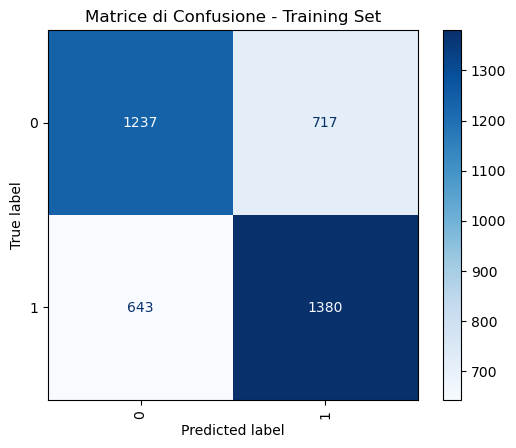

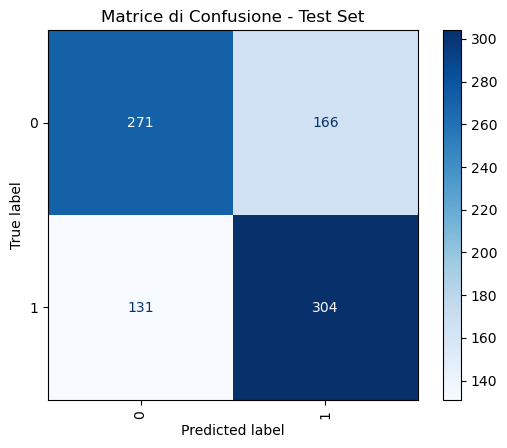

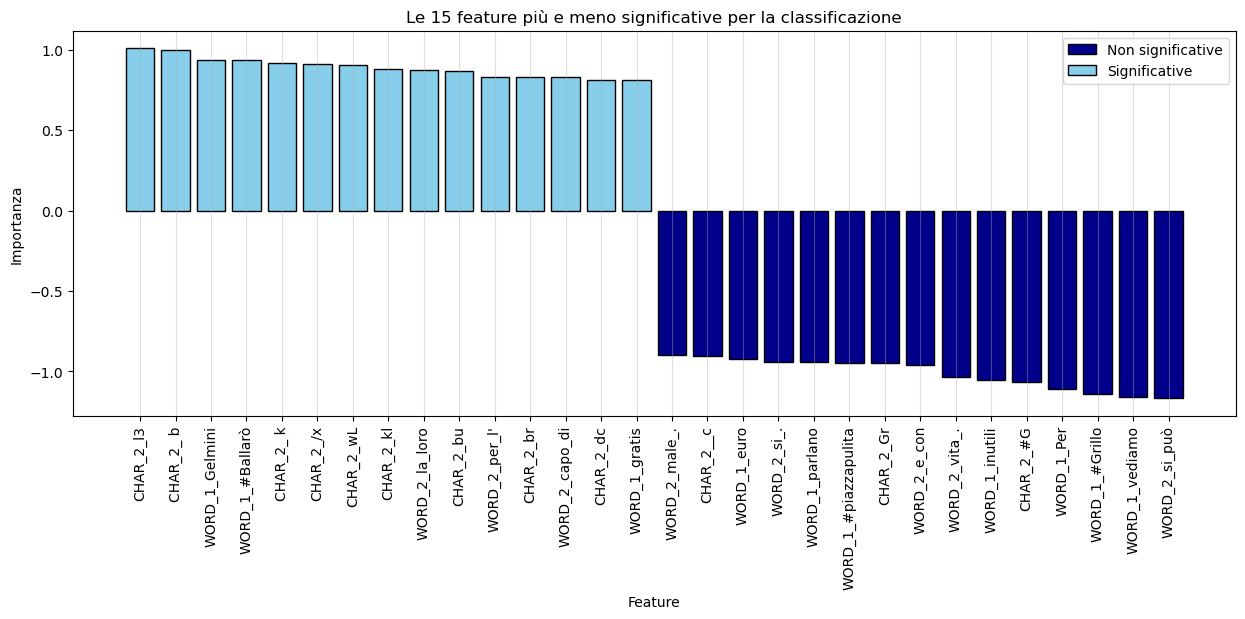

--------------------------------------------------------------------------------------------------------------------
 
 Classificazione svolta su feature estratte a partire da bigrammi e trigrammi di caratteri e parole. 

 Dimensione del fold  1  di train e validation:  3181 , 796
 Dimensione del fold  2  di train e validation:  3181 , 796
 Dimensione del fold  3  di train e validation:  3182 , 795
 Dimensione del fold  4  di train e validation:  3182 , 795
 Dimensione del fold  5  di train e validation:  3182 , 795


Accuracy su fold 1: 0.6394472361809045
Accuracy su fold 2: 0.6532663316582915
Accuracy su fold 3: 0.6641509433962264
Accuracy su fold 4: 0.660377358490566
Accuracy su fold 5: 0.6540880503144654
 
 Valutazione sul training set completo: 


               precision    recall  f1-score   support

           0       0.65      0.64      0.65      1954
           1       0.66      0.67      0.66      2023

    accuracy                           0.65      3977
   macro avg      

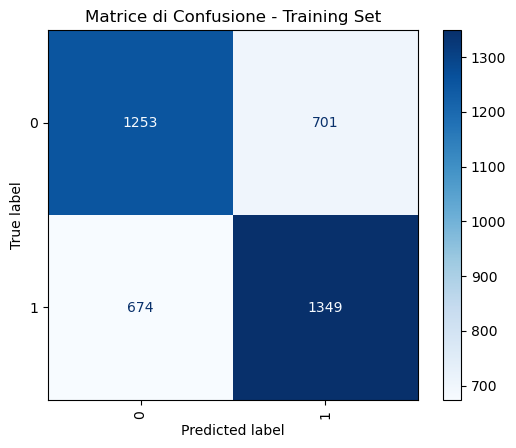

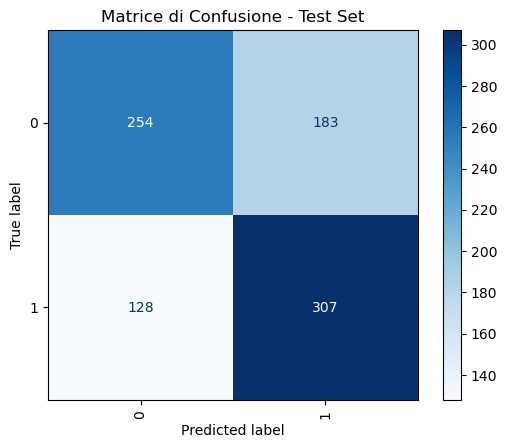

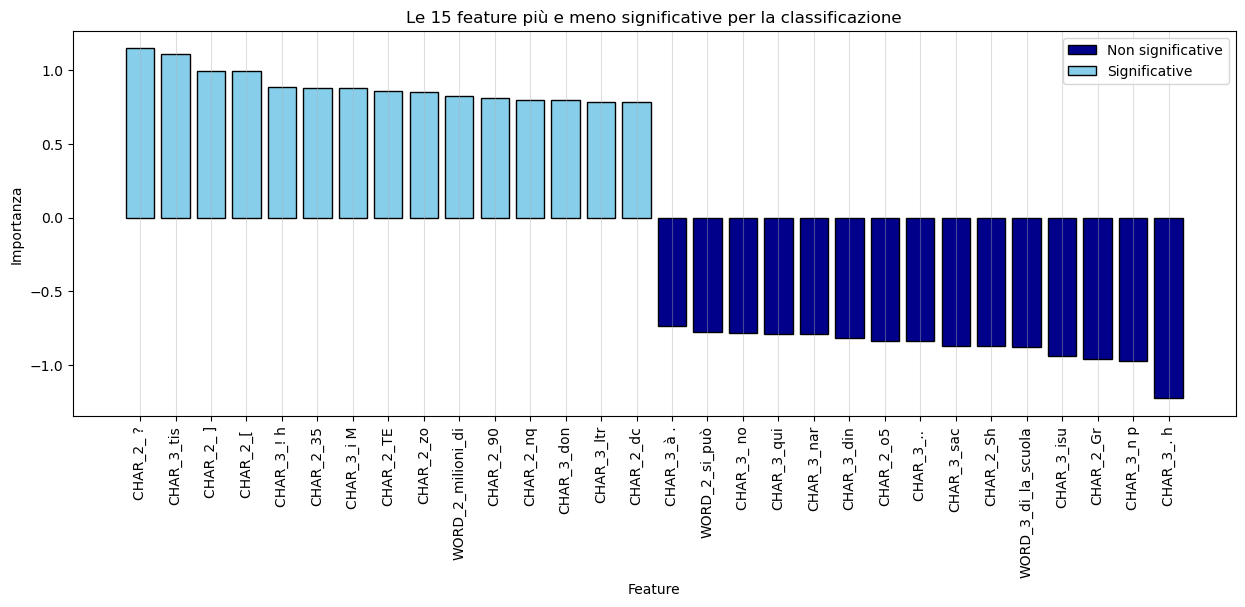

--------------------------------------------------------------------------------------------------------------------
 
 Classificazione svolta su feature estratte a partire da unigrammi e trigrammi di part of speech e parole. 

 Dimensione del fold  1  di train e validation:  3181 , 796
 Dimensione del fold  2  di train e validation:  3181 , 796
 Dimensione del fold  3  di train e validation:  3182 , 795
 Dimensione del fold  4  di train e validation:  3182 , 795
 Dimensione del fold  5  di train e validation:  3182 , 795


Accuracy su fold 1: 0.6733668341708543
Accuracy su fold 2: 0.6582914572864321
Accuracy su fold 3: 0.6490566037735849
Accuracy su fold 4: 0.6716981132075471
Accuracy su fold 5: 0.6377358490566037
 
 Valutazione sul training set completo: 


               precision    recall  f1-score   support

           0       0.66      0.63      0.65      1954
           1       0.66      0.68      0.67      2023

    accuracy                           0.66      3977
   macro av

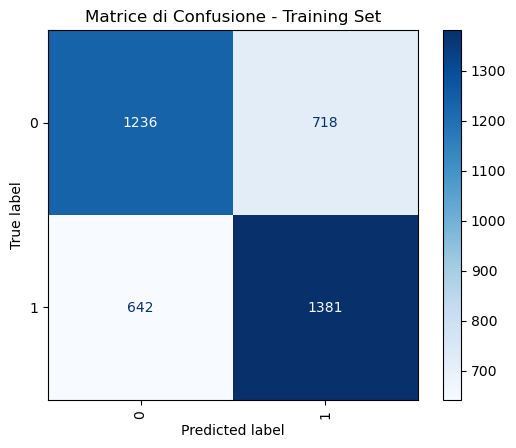

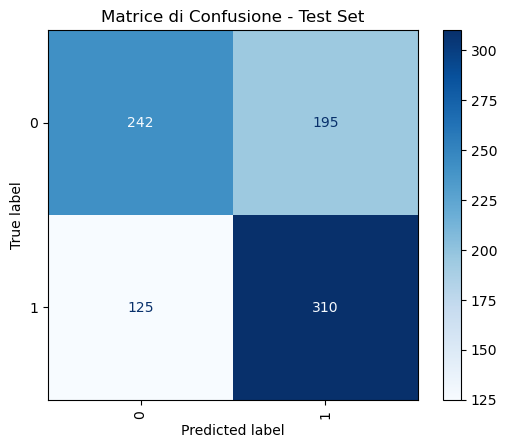

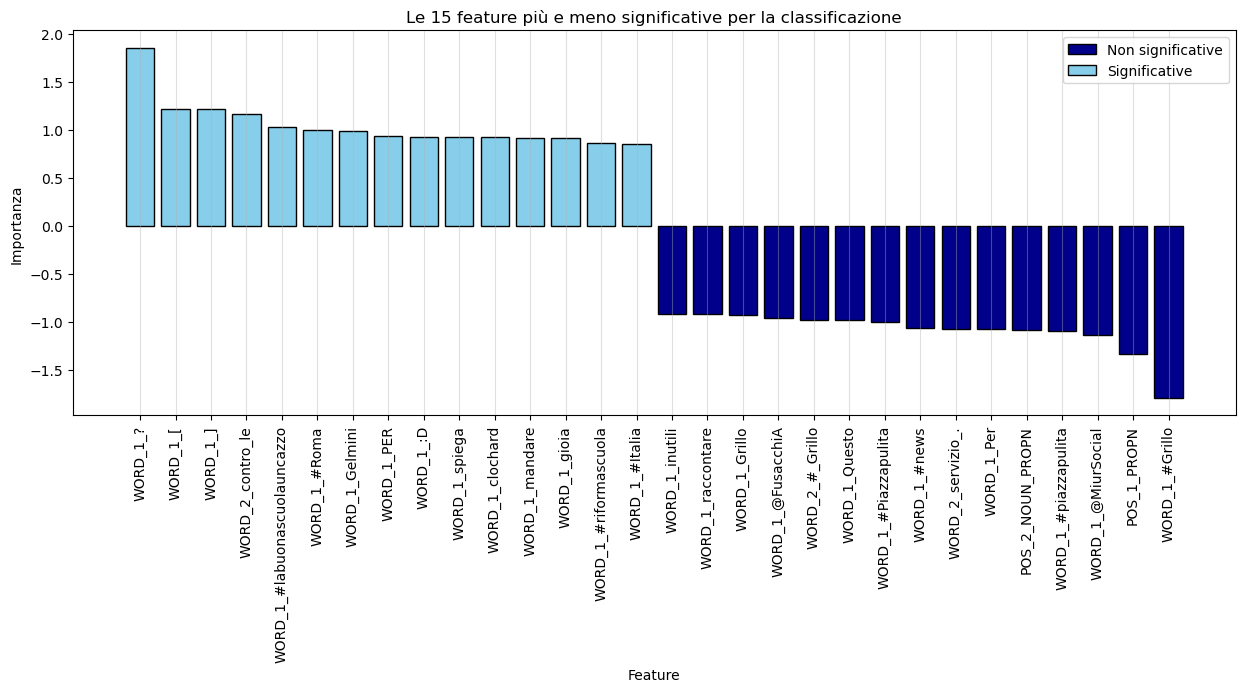

--------------------------------------------------------------------------------------------------------------------


In [82]:
typeFeat_1 = "unigrammi e bigrammi di caratteri e parole";
typeFeat_2 = "bigrammi e trigrammi di caratteri e parole";
typeFeat_3 = "unigrammi e trigrammi di part of speech e parole";

# Classificazione sul dataset le cui feature consistono in bigrammi e unigrammi di caratteri e parole 
k5fold_classification(train_features_1, test_features_1, y_train, y_test, typeFeat_1)
# Classificazione sul dataset le cui feature consistono in bigrammi e trigrammi di caratteri e parole 
k5fold_classification(train_features_2, test_features_2, y_train, y_test, typeFeat_2) 
# Classificazione sul dataset le cui feature consistono in unigrammi e bigrammi di pos e parole 
k5fold_classification(train_features_3, test_features_3, y_train, y_test, typeFeat_3) 

# Parte 3
Sviluppare un classificatore basato su SVM lineari che prende in input una rappresentazione del testo costruita attraverso l’uso dei word embedding (http://www.italianlp.it/resources/italian-word-embeddings/). Riportare i seguenti risultati:
- testare diverse rappresentazioni del testo che variano rispetto al modo di combinare gli embedding delle singole parole e/o rispetto alle categorie grammaticali delle parole prese in considerazione. Valutare i diversi sistemi con un processo di 5-fold cross validation condotto sul training set.
- valutazione sul test set ufficiale del miglior sistema rispetto ai risultati ottenuti con il processo di 5-fold cross validation del punto sopra .

### Attenzione

Pre-requisiti nel caso si preferisca eseguire solo questa parte e non le altre: impostare la cella che segue in modalità code ed eseguire.

Non è necessario eseguire la cella che segue se si preferisce eseguire l'intero notebook a cascata.

In [ ]:
# Salvo in un numpy array le classi del train set
y_train = np.asarray(y_train)

## Caricamento degli embeddings

In [5]:
# Dimensione embedding
embeddings_dim = 32
# Caricamento senza splitting dei clitici e delle preposizioni
embeddings_path_not = f'data/word_embeddings/twitter_Not_{embeddings_dim}.txt'

In [6]:
# La funzione legge un file di embeddings delle parole, e riga per riga estrae la parola (chiave) e il vettore di embedding (valore) corrispondente restituendoli all'interno di un dizionario.
def load_word_embeddings(src_path):

    # Inizializza un dizionario vuoto che conterrà gli embeddings delle parole
    embeddings = dict() 
    
    # Itera sulle righe del file di embeddings
    for line in open(src_path, 'r', encoding='utf-8'):  
        # Rimuove gli spazi e separa la riga in due parti in base al carattere di tabulazione
        line = line.strip().split('\t')  
        # La parola è il primo elemento della riga
        word = line[0]  
        # Gli embeddings sono tutti gli altri elementi della riga
        embedding = line[1:]  
        # Imponi ad ogni elemento degli embedding il tipo float
        embedding = [float(comp) for comp in embedding]
        # Inserisci elemento nel dizionario: avrà la chiave word e il valore sarà l'embedding di tipo array
        embeddings[word] = np.asarray(embedding)  
    
    return embeddings  

In [ ]:
# Salvo gli embedding 
embeddings = load_word_embeddings(embeddings_path_not)

## Funzioni per preparare i testi dei tweet

In [ ]:
# Funzione per gestire i numeri nei testi
def get_digits(text):
    try:
        # Converte la stringa 'text' in un intero
        val = int(text)
    # Nel caso non fosse possibile
    except:
        # Sostituisce tutti i caratteri numerici nella stringa con '@Dg' e restituisce la stringa
        text = re.sub('\d', '@Dg', text)
        return text
    
    # Verifica se il valore intero è compreso tra 0 e 2099
    if val >= 0 and val < 2100:
        # Restituisce il valore convertito in stringa
        return str(val)
    # Se non è compreso
    else:
        # Restituisce la stringa "DIGLEN_" seguita dalla lunghezza della stringa rappresentante il valore intero
        return "DIGLEN_" + str(len(str(val)))

In [ ]:
# Funzione per preparare le singole parole
def normalize_text(word):
    
    # Se la parola contiene "http" o "." e "/"
    if "http" in word or ("." in word and "/" in word):
        # Sostituisce la parola con la stringa "___URL___" e la restituisce
        word = str("___URL___")
        return word
    
    # Se la lunghezza della parola è superiore a 26
    if len(word) > 26:
        # Restituisce la stringa che segue
        return "__LONG-LONG__"
    
    # Ottiene una nuova parola applicando la funzione get_digits alla parola corrente
    new_word = get_digits(word)
    
    # Se la nuova parola è diversa dalla parola originale
    if new_word != word:
        # Assegna la nuova parola alla variabile word
        word = new_word
        
    # Se il primo carattere della parola è maiuscolo
    if word[0].isupper():
        # Converte la parola iniziale in maiuscolo
        word = word.capitalize()
    else:
        # Converte la parola iniziale in minuscolo
        word = word.lower()
        
    # Restituisce la parola modificata
    return word

In [ ]:
# Funzione che restituisce una lista di token  per ogni tweet, formattati in modo compatibile con gli embeddings 
def get_tokens_from_file(src_path):
    
    # Lista per memorizzare i token dei tweet
    tweet_tokens = []
     # Numero di righe da saltare
    lines_to_skip = 0
    # Flag per indicare se prendere la parte del discorso (POS) della prossima parola
    take_pos = False
    
    # Apre il file src_path in modalità lettura e itera sulle righe
    for line in open(src_path, 'r', encoding='utf-8'):
        #print(f'\nRiga: {line.strip()}')

        # Se il primo elemento della riga è un numero si procede al controllo dei token
        if line[0].isdigit():
            
            # Divide la riga in base al tabulatore '\t' e rimuove eventuali spazi bianchi
            splitted_line = line.strip().split('\t')
            
            # Se all'interno del primo elemento di splitted line è presente un trattino
            if '-' in splitted_line[0]:
                
                # Divide l'indice numerico della riga iniziale e finale separatamente
                skip_ids = splitted_line[0].split('-')
            
                # Calcola il numero di righe da saltare tramite gli id
                lines_to_skip = int(skip_ids[1]) - int(skip_ids[0]) + 1 
                # Imposta il flag per prendere la posizione della prossima parola
                take_pos = True 
                # Ottiene una parola normalizzata applicando la funzione normalize_text alla parola corrente
                word = normalize_text(splitted_line[1])
                # Salva la parte del discorso (pos) della parola
                pos = splitted_line[3]
                
                token = {
                    'word': word,
                    'pos': pos
                }
                # Aggiunge il token alla lista dei token del tweet
                tweet_tokens.append(token)
              
            # Altrimenti se non è presente un trattino
            else:
                
                # Se non ci sono righe da saltare
                if lines_to_skip == 0:
                    
                    # Ottiene una parola normalizzata applicando la funzione normalize_text alla parola corrente
                    word = normalize_text(splitted_line[1])
                    # Salva la parte del discorso (pos) della parola 
                    pos = splitted_line[3]
                    token = {
                        'word': word,
                        'pos': pos
                    }
                    
                    # Aggiunge il token alla lista dei token del tweet
                    tweet_tokens.append(token)
                
                
                # Se take_pos è true, quindi è necessario prendere la parte del discorso (pos)
                if take_pos:
                    
                    # Salva la parte del discorso (pos) della parola
                    pos = splitted_line[3]
                    # Assegna la parte del discorso (pos) all'ultimo token nella lista dei token del tweet
                    tweet_tokens[-1]['pos'] = pos
                    # Reimposta il flag di take_pos a False
                    take_pos = False
                # Decrementa il numero di righe da saltare
                lines_to_skip = max(0, lines_to_skip-1)
                
    # Restituisce la lista dei token del tweet
    return tweet_tokens

In [ ]:
# Lista per memorizzare i dataset di train e test
train_dataset = []
test_dataset = []

def create_df(df_of_paths, final_df):
    
    # Itera sui percorsi dei tweet nel dataset
    for tweet_path in df_of_paths:
        # Ottiene i token dal file del tweet
        tweet_sentences = get_tokens_from_file(tweet_path)
        # Aggiunge i token alla lista finale dei dataset
        final_df.append(tweet_sentences)

# Crea il dataset di train e test
create_df(train_files, train_dataset)
create_df(test_files, test_dataset)

In [ ]:
# Controllo se il numero di file corrispondono all'effettiva dimensione dei set
print('Documenti training set:', len(train_dataset))
print('Documenti test set:', len(test_dataset))

Documenti training set: 3977
Documenti test set: 872


In [ ]:
print("\"Tokens\" presenti nel primo tweet del train set: \n", train_dataset[0])

"Tokens" presenti nel primo tweet del train set: 
 [{'word': 'Le', 'pos': 'DET'}, {'word': '5', 'pos': 'NUM'}, {'word': 'sgradevoli', 'pos': 'ADJ'}, {'word': 'realtà', 'pos': 'NOUN'}, {'word': 'di', 'pos': 'ADP'}, {'word': 'cui', 'pos': 'PRON'}, {'word': 'Berlusconi', 'pos': 'PROPN'}, {'word': 'dovrebbe', 'pos': 'AUX'}, {'word': 'rendersi', 'pos': 'VERB'}, {'word': 'personalmente', 'pos': 'ADV'}, {'word': 'conto', 'pos': 'NOUN'}, {'word': '___URL___', 'pos': 'PROPN'}, {'word': 'Mario', 'pos': 'PROPN'}, {'word': 'Monti', 'pos': 'PROPN'}, {'word': 'non', 'pos': 'ADV'}, {'word': 'usa', 'pos': 'VERB'}, {'word': 'mezzi', 'pos': 'ADJ'}, {'word': 'termini', 'pos': 'NOUN'}]


## Fase di generazione della matrice di features utilizzando gli embedding

In [ ]:
# Calcola la media degli embedding dei tweet
def compute_embeddings_mean(tweet_embeddings):
     
    # Somma gli embedding dei tweet
    sum_array = np.sum(tweet_embeddings, axis=0)
    # Divide la somma per il numero di embedding dei tweet per ottenere la media
    mean_array = np.divide(sum_array, len(tweet_embeddings))
    return mean_array

### 1) Logica per l'estrazione delle feature: Calcola la media di tutti gli embedding dei tweet 

In [ ]:
# Calcola la media (tramite compute_embeddings_mean) di tutti gli embedding dei tweet 
def compute_all_embeddings_mean(tweet_tokens):
    
     # Inizializza una lista vuota per memorizzare gli embedding dei tweet
    tweet_embeddings = []
    
    # Per ogni token nei tweet
    for token in tweet_tokens:
        
        # Salvo la word del token
        word = token['word']
        
        # Se tale word è presente negli embeddings
        if word in embeddings:
            # Aggiungo alla lista degli embedding l'embedding di word
            tweet_embeddings.append(embeddings[word])
    
    # Se la lista contenente gli embedding contiene 0 elementi
    if len(tweet_embeddings) == 0:
        # Creo un embedding riempito di zeri
        tweet_embeddings = [np.zeros(embeddings_dim)]
    
    # Calcola la media degli embeddings dei tweet (invoca compute_embeddings_mean)
    tweet_embeddings = compute_embeddings_mean(tweet_embeddings)
    return tweet_embeddings

### 2) Logica per l'estrazione delle feature: Calcola la media degli embedding filtrati per POS dei tweet

In [ ]:
# Calcola la media (tramite compute_embeddings_mean) degli embedding filtrati per POS dei tweet
def compute_filtered_embeddings_mean(tweet_tokens):
    
    # Inizializza una lista vuota per memorizzare gli embedding filtrati dei tweet
    tweet_embeddings = []
    
    # Per ogni token nei token dei tweet
    for token in tweet_tokens:
        # Prendo la parola e il POS (parte del discorso) dal token
        word = token['word']
        pos = token['pos']
        
        # Verifica se la parola è presente nelle incapsulazioni e se il POS è 'ADJ', 'NOUN' o 'VERB'
        if word in embeddings and pos in ['ADJ', 'NOUN', 'VERB']:
            # Aggiungo alla lista degli embedding l'embedding di word
            tweet_embeddings.append(embeddings[word])
            
     # Se la lista contenente gli embedding contiene 0 elementi
    if len(tweet_embeddings) == 0:
        # Creo un embedding riempito di zeri
        tweet_embeddings = [np.zeros(embeddings_dim)]
    
    # Calcola la media degli embedding dei tweet filtrati per POS (invoca compute_embeddings_mean)
    tweet_embeddings = compute_embeddings_mean(tweet_embeddings)
    return tweet_embeddings

### 3) Logica per l'estrazione delle feature: Calcola la media degli embedding filtrati in base al POS, facendo distinzione tra aggettivi, sostantivi e verbi

In [ ]:
# Calcola la media degli embedding dei tweet filtrate in base al POS separando gli aggettivi, i sostantivi e i verbi per poi concatenarli.
def compute_filtered_embeddings_sep_means(tweet_tokens):
    
    # Inizializza le liste per le incapsulazioni separate degli aggettivi, dei sostantivi e dei verbi
    adj_embeddings = []
    noun_embeddings = []
    verb_embeddings = []
    
    # Per ogni token nei token del tweet
    for token in tweet_tokens:
        
        # Prendo la parola e il POS (parte del discorso) dal token
        word = token['word']
        pos = token['pos']
        
        # Se la parola è presente negli embeddings e se il POS è 'ADJ' (aggettivo)
        if word in embeddings and pos in ['ADJ']:
            # Aggiunge l'embeddings della parola alla lista adj_embeddings
            adj_embeddings.append(embeddings[word])
        # Se la parola è presente negli embeddings e se il POS è 'NOUN' (nome)
        elif word in embeddings and pos in ['NOUN']:
             # Aggiunge l'embeddings della parola alla lista noun_embeddings
            noun_embeddings.append(embeddings[word])
        # Se la parola è presente negli embeddings e se il POS è 'VERB' (verbo)
        elif word in embeddings and pos in ['VERB']:
             # Aggiunge l'embeddings della parola alla lista verb_embeddings
            verb_embeddings.append(embeddings[word])
    
    # Se non vengono trovati embeddings per gli aggettivi,nomi e verbi crea un embedding riempito di zeri per ciascuno
    if len(adj_embeddings) == 0:
        adj_embeddings = [np.zeros(embeddings_dim)]
    if len(noun_embeddings) == 0:
        noun_embeddings = [np.zeros(embeddings_dim)]
    if len(verb_embeddings) == 0:
        verb_embeddings = [np.zeros(embeddings_dim)]
        
    # Calcola la media degli embeddings per gli aggettivi, i sostantivi e i verbi
    adj_embeddings = compute_embeddings_mean(adj_embeddings)
    noun_embeddings = compute_embeddings_mean(noun_embeddings)
    verb_embeddings = compute_embeddings_mean(verb_embeddings)
    
     # Concatena gli embeddings con le medie degli aggettivi, dei sostantivi e dei verbi 
    tweet_embeddings = np.concatenate([adj_embeddings, noun_embeddings, verb_embeddings], axis=None)
    return tweet_embeddings

In [ ]:
# Estrae le feature dai tweet presenti nel dataset fornito utilizzando la logica 1
def extract_features_1(dataset):
    
    dataset_features = []
    # Per ogni "Token" nei tweet nel dataset
    for tweet_tokens in dataset:
        # Calcola gli embeddings medi del tweet utilizzando una delle tre funzioni seguenti:
        tweet_embeddings = compute_all_embeddings_mean(tweet_tokens)
        # Appendo il risultato della funzione utilizzata a dataset_features
        dataset_features.append(tweet_embeddings)
    return dataset_features

In [ ]:
# Estrae le feature dai tweet presenti nel dataset fornito utilizzando la logica 2
def extract_features_2(dataset):
    
    dataset_features = []
    # Per ogni "Token" nei tweet nel dataset
    for tweet_tokens in dataset:
        # Calcola gli embeddings medi del tweet utilizzando una delle tre funzioni seguenti:
        tweet_embeddings = compute_filtered_embeddings_mean(tweet_tokens)  
        # Appendo il risultato della funzione utilizzata a dataset_features
        dataset_features.append(tweet_embeddings)
    return dataset_features

In [ ]:
# Estrae le feature dai tweet presenti nel dataset fornito utilizzando la logica 3
def extract_features_3(dataset):
    
    dataset_features = []
    # Per ogni "Token" nei tweet nel dataset
    for tweet_tokens in dataset:
        # Calcola gli embeddings medi del tweet utilizzando una delle tre funzioni seguenti:
        tweet_embeddings = compute_filtered_embeddings_sep_means(tweet_tokens)
        # Appendo il risultato della funzione utilizzata a dataset_features
        dataset_features.append(tweet_embeddings)
    return dataset_features

In [ ]:
# Estraggo features dal train e test set con i 3 approcci
train_features_1 = extract_features_1(train_dataset)
test_features_1 = extract_features_1(test_dataset)

train_features_2 = extract_features_2(train_dataset)
test_features_2 = extract_features_2(test_dataset)

train_features_3 = extract_features_3(train_dataset)
test_features_3 = extract_features_3(test_dataset)

In [24]:
# Esegue la cross fold validation utilizzando LinearSVC; 
# Applica la normalizzazione Min-Max alle features, suddivide il training set in fold e valuta le prestazioni del modello su ogni fold. 
# Successivamente, valuta le prestazioni del modello sul test set.

def perform_kfold_cross_validation(train_features, test_features, y_train, y_test, invocation):

    print(f"Risultati per la classificazione effettuata utilizzando la logica {invocation} di estrazione delle features: \n")
    
    # Normalizzazione Min-Max
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train_features)
    X_test = scaler.transform(test_features)

    # Suddivisione del training set in fold
    splitter = KFold(n_splits=5, random_state=42, shuffle=True)
    folds = list(splitter.split(X_train))
    for i in range(len(folds)):
        print(" Dimensione del fold ",(i+1), " di train e validation: ",len(folds[i][0]),",", len(folds[i][1]))

    # Lista per memorizzare le predizioni e le classi reali su tutti i fold
    all_y_true = []
    all_y_pred = []

    print("\n")
    # Per ciascun fold
    for i in range(len(folds)):
        
        # Estraggo gli indici di train e validation (qui e di seguito definito test) per il fold corrente
        train_ids = folds[i][0]
        test_ids = folds[i][1]

        # Suddivido i dati in train e validation per il fold corrente tramite la localizzazione degli ID estratti in folds
        fold_X_train = X_train[train_ids]
        fold_y_train = y_train[train_ids]

        fold_X_test = X_train[test_ids]
        fold_y_test = y_train[test_ids]

        # Addestramento del modello LinearSVC
        kfold_svc = LinearSVC(dual= False)
        kfold_svc.fit(fold_X_train, fold_y_train)

        # Predizione sul fold di test (validation)
        fold_y_pred = kfold_svc.predict(fold_X_test)
        # Calcolo l'accuratezza del modello sul fold corrente
        fold_accuracy = accuracy_score(fold_y_test, fold_y_pred)
    
        # Aggiungo a queste due variabili le predizioni e i valori reali delle label 
        all_y_true += fold_y_test.tolist()
        all_y_pred += fold_y_pred.tolist()
        
        # Stampo accuracy del fold corrente
        print(f"Accuracy su fold {i+1}: {fold_accuracy}")
       
 
    # Valutazione sul training set completo tramite classification report
    print(" \n Valutazione sul training set completo: \n")
    print(classification_report(all_y_true, all_y_pred, zero_division=0),"\n")
    
    
    # Valutazione sul test set tramite classification report
    print(" \n Valutazione sul test set: \n")
    test_predictions = kfold_svc.predict(X_test)
    print(classification_report(y_test, test_predictions, zero_division=0),"\n")
  
    
    # Matrice di confusione sul training set completo
    cm_train = confusion_matrix(all_y_true, all_y_pred)
    disp_train = ConfusionMatrixDisplay(cm_train)
    disp_train.plot(xticks_rotation='vertical', cmap='Blues')
    plt.title(f"Matrice di Confusione - Training Set - Logica {invocation}")
    plt.show()

    # Matrice di confusione sul test set
    cm_test = confusion_matrix(y_test, test_predictions)
    disp_test = ConfusionMatrixDisplay(cm_test)
    disp_test.plot(xticks_rotation='vertical', cmap='Blues')
    plt.title(f"Matrice di Confusione - Test Set - Logica {invocation}")
    plt.show()

    print("-----------------------------------------------------------------------------------------------------------------------------------")
    

Risultati per la classificazione effettuata utilizzando la logica 1 di estrazione delle features: 

 Dimensione del fold  1  di train e validation:  3181 , 796
 Dimensione del fold  2  di train e validation:  3181 , 796
 Dimensione del fold  3  di train e validation:  3182 , 795
 Dimensione del fold  4  di train e validation:  3182 , 795
 Dimensione del fold  5  di train e validation:  3182 , 795


Accuracy su fold 1: 0.7223618090452262
Accuracy su fold 2: 0.7135678391959799
Accuracy su fold 3: 0.7182389937106918
Accuracy su fold 4: 0.7018867924528301
Accuracy su fold 5: 0.7157232704402515
 
 Valutazione sul training set completo: 

              precision    recall  f1-score   support

           0       0.72      0.67      0.70      1954
           1       0.71      0.75      0.73      2023

    accuracy                           0.71      3977
   macro avg       0.72      0.71      0.71      3977
weighted avg       0.72      0.71      0.71      3977
 

 
 Valutazione sul test set: 


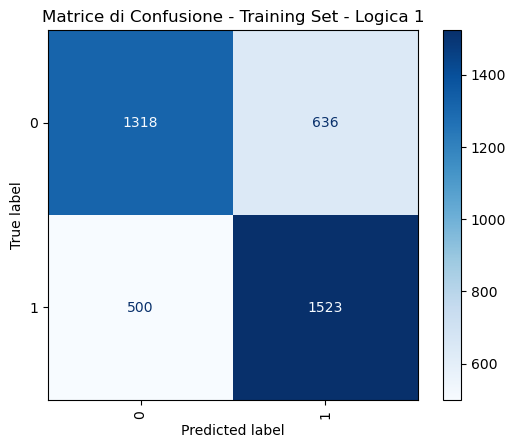

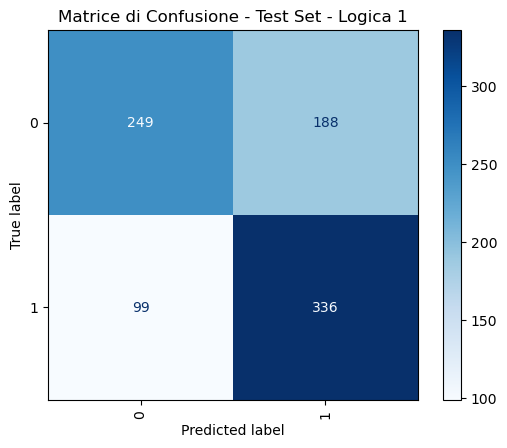

-----------------------------------------------------------------------------------------------------------------------------------
Risultati per la classificazione effettuata utilizzando la logica 2 di estrazione delle features: 

 Dimensione del fold  1  di train e validation:  3181 , 796
 Dimensione del fold  2  di train e validation:  3181 , 796
 Dimensione del fold  3  di train e validation:  3182 , 795
 Dimensione del fold  4  di train e validation:  3182 , 795
 Dimensione del fold  5  di train e validation:  3182 , 795


Accuracy su fold 1: 0.6582914572864321
Accuracy su fold 2: 0.6595477386934674
Accuracy su fold 3: 0.6716981132075471
Accuracy su fold 4: 0.6515723270440251
Accuracy su fold 5: 0.6427672955974842
 
 Valutazione sul training set completo: 

              precision    recall  f1-score   support

           0       0.65      0.65      0.65      1954
           1       0.66      0.66      0.66      2023

    accuracy                           0.66      3977
   macro 

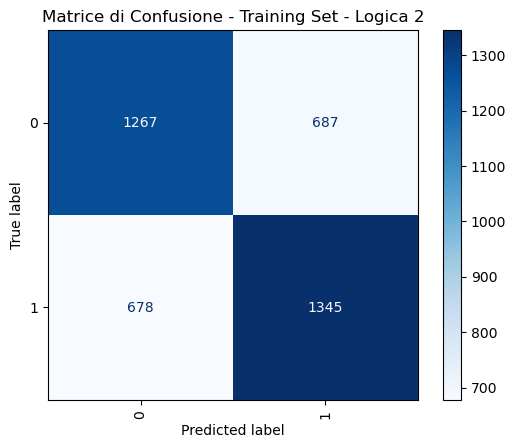

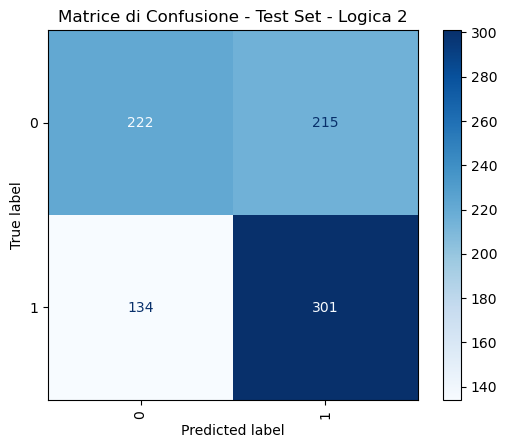

-----------------------------------------------------------------------------------------------------------------------------------
Risultati per la classificazione effettuata utilizzando la logica 3 di estrazione delle features: 

 Dimensione del fold  1  di train e validation:  3181 , 796
 Dimensione del fold  2  di train e validation:  3181 , 796
 Dimensione del fold  3  di train e validation:  3182 , 795
 Dimensione del fold  4  di train e validation:  3182 , 795
 Dimensione del fold  5  di train e validation:  3182 , 795


Accuracy su fold 1: 0.6545226130653267
Accuracy su fold 2: 0.6293969849246231
Accuracy su fold 3: 0.6490566037735849
Accuracy su fold 4: 0.630188679245283
Accuracy su fold 5: 0.640251572327044
 
 Valutazione sul training set completo: 

              precision    recall  f1-score   support

           0       0.63      0.64      0.64      1954
           1       0.65      0.64      0.64      2023

    accuracy                           0.64      3977
   macro av

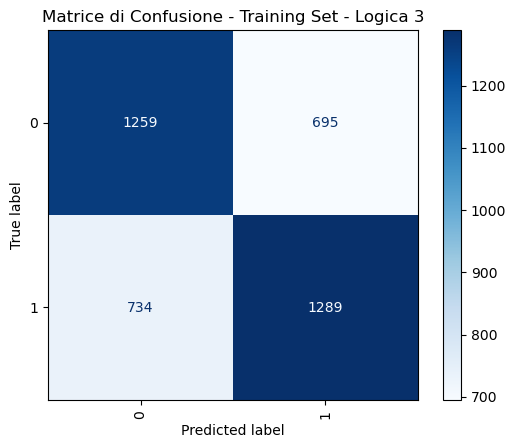

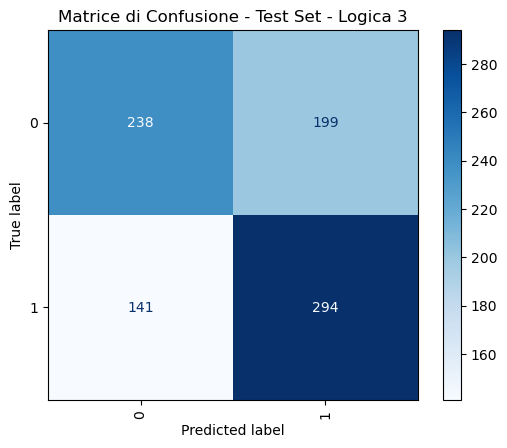

-----------------------------------------------------------------------------------------------------------------------------------


In [25]:
# Realizzo cross-validation utilizzando le features estratte tramite l'utilizzo delle tre diverse logiche
perform_kfold_cross_validation(train_features_1, test_features_1, y_train, y_test, 1)
perform_kfold_cross_validation(train_features_2, test_features_2, y_train, y_test, 2)
perform_kfold_cross_validation(train_features_3, test_features_3, y_train, y_test, 3)